# Titanic competition 

### Michael Gallimore 15 Feb 2021

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/titanic/"

In [4]:
!ls $PATH

gender_submission.csv  test.csv  titanic_raw  titanic.zip  train.csv


low_memory = false reads more of the file to decide what the types are. parse_dates contains a list of any columns containing dates.

In [5]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

create a display all function

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, 
                           "display.max_columns", 1000):
        display(df)

In [7]:
display_all(df_raw.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


describe method on a pandas dataframe shows the spread of the data in each category. include='all' is more detailed. 

In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Name,891,891,"Kent, Mr. Edward Austin",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Ticket,891,681,CA. 2343,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329


### Take log of error if required



In [9]:
#df_raw.dependent_variable = np.log(df_raw.dependent_variable)

In [10]:
#display_all(df_raw.tail().T)

## Initial Processing 

In [11]:
#df_raw

### make a scikit learn ML model instance:
1. create an instance of the machine learning method you want to use
2. call fit passing in the independent variable and the dependent variable. 
pandas dataframe.drop() method returns a new dataframe with the specified column removed. 

### Feature engineering:
#### most machine learning algorithms take input in numerical form, so we need to convert any strings into numbers. We can also pull out some meaningful features from the date - for example:
Was it raining that day?
Was there a sports event that day?
What month / quarter / season is it?
Was there a superbowl event that day?

This data contains a mix of <strong> continuous </strong> and <b> categorical </b> data. 

The following method extracts particular date fields from the datetime for the purpose of constructing categoricals. Always consider this step otherwise you can't capture any trend/cyclical behaviour as a function of time at any of these granularities. #


In [12]:
#??add_datepart


holding down tab key shows the methods available 

In [13]:
#fld = df_raw.saledate
#fld
# fld.dt
# fld.dt.year


since we passed 'saledate' into parse_dates earlier, the values in this column will be pandas date type or df.dt 
we can then use the fastai.structured method add_datepart which will pull out some categorical features of these dates. The original saledate column will be removed since it is not useable since it is not a number. 

The column will be split into different enumerable categories named sale'category'

In [14]:
#add_datepart(df_raw, 'saledate')
#df_raw.saleYear.head()

## String values
there are more columns containing strings in the dataset. Eg. low, med, high. use train_cats to make strings into numbers. Behind the scenes this creates a column which is an integer, and stores a mapping from the integers to the strings. 

Make sure the mappings from strings to numbers are the same in the training set as they are in the validation set. This is achieved by using train cats to determine the mappings, then  using the function apply_cats to apply the same mappings to a new dataset. 

In [15]:
df_raw.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df_raw.to_feather('data/titanic/titanic_raw')

In [17]:
df_raw = pd.read_feather('data/titanic/titanic_raw')

In [18]:
df_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,None,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,None,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [19]:
## check for marriage prefix and add a new column to pandas dataframe
strings = ['Mr.', 'Mrs.', 'MR', 'MRS']
def feature_extract(column, strings, ):
    features_present = [0] * len(column)
    for index, name in enumerate(column):
        for string in strings:
            if string in name:
                features_present[index] = 1
    return features_present

features = feature_extract(df_raw.Name, strings)

df_raw.insert(4, "Married", features, True)


In [20]:
display_all(df_raw)

,PassengerId,Survived,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,male,22.00,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.00,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,female,26.00,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.00,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,male,35.00,0,0,373450,8.0500,None,S
5,6,0,3,"Moran, Mr. James",1,male,NaN,0,0,330877,8.4583,None,Q
6,7,0,1,"McCarthy, Mr. Timothy J",1,male,54.00,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",0,male,2.00,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,female,27.00,0,2,347742,11.1333,None,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,female,14.00,1,0,237736,30.0708,None,C


In [21]:
# def string_length(column):
#     features_present = [0] * len(column)
#     for index, name in enumerate(column):
#         for string in strings:
#             if string in name:
#                 features_present[index] = 1
#     return features_present

# features = feature_extract(df_raw.Name, strings)

# df_raw.insert(4, "Married", features, True)
    
# df_raw

In [22]:
train_cats(df_raw)

Now we have trained the categories, any previous string data will now have a .cat CategoricalAssessor object which we can look at. Previously numerical data will not have this new .cat property.

In [23]:
df_raw.Cabin.cat.codes

0      -1
1      81
2      -1
3      55
4      -1
       ..
886    -1
887    30
888    -1
889    60
890    -1
Length: 891, dtype: int16

we can put these in a more sensible order by using set_categories. inplace means it will change the existing dataframe rather than return a new dataframe. 


In [24]:
# df_raw.UsageBand.cat.set_categories(['High', 'Medium','Low'], ordered=True, inplace=True)
# df_raw.UsageBand.cat.categories

Missing values will be given the value -1

We still have lots of missing values which we can't pass directly to a random forest
isnull() returns True or False depending on whether something is empty
sum() adds how many 
sort and divide by size of dataset

output shows some columns have quite high percentages of missing values. 

In [25]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Age            0.198653
Cabin          0.771044
Embarked       0.002245
Fare           0.000000
Married        0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.000000
Ticket         0.000000
dtype: float64

## proc_df

Using proc_df we'll <strong>handle missing continuous variables</strong>, <strong>replace categories with their numeric codes</strong> and <strong>split the dependent vatiable</strong> (log saleprice) into a separate variable. 

missing variables are filled using fix_missing method called inside proc_df. It verifies that there are missing values, then creates a new column with same name as original plus '_na' . this column will contain a 1 any time the data was missing and a 0 any time it wasn't. Finally the fillna function fills any missing values with the col.median() of the column. 

for the categorical data, pandas already set the missing values to minus -1 and the rest of the caegories to 0,1,2,3, etc. We want missing to be zero, so numericalize() is called by proc_df to add one to all of the cat codes and to convert all of the recently converted category types into integers. 

finally the dependent variable is separated out into a new variable called y


In [26]:
df, y, nas = proc_df(df_raw, 'Survived')

## Saving
To save the data in .feather format, use the .to_feather method. save to tmp folder. 


In [27]:
os.makedirs('tmp', exist_ok=True)

In [28]:
df.to_feather('tmp/titanic_trained_raw')

In [29]:
!ls tmp/

titanic_trained_raw


## loading

In [30]:
df = pd.read_feather('tmp/titanic_trained_raw')


In [31]:
# df, y = proc_df(df_raw, 'SalePrice')
df.head()


,PassengerId,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,109,1,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,191,1,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,354,0,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,273,1,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,16,1,2,35.0,0,0,473,8.0500,0,3,False


In [32]:
nas

{'Age': 28.0}

In [33]:
df.columns ## notice new _na columns on the end

Index(['PassengerId', 'Pclass', 'Name', 'Married', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_na'],
      dtype='object')

In [34]:
df.Age


0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [35]:
df.head() # Everything is a number!

,PassengerId,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,109,1,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,191,1,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,354,0,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,273,1,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,16,1,2,35.0,0,0,473,8.0500,0,3,False


In [36]:
y.size


891

Random forests are trivially parallisable, meaning that the data will be split across all cpus so more cpus means faster processing. 
n_jobs = -1 means make a new job for each processor available.

In [37]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(df, y)
m.score(df, y)


/home/mike/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mike/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.8975452976704055

A score of 0.98 looks great, but we may be overfitting or some other way biased. We need to split the data into a training set and validation set.

    Generally speaking, being in the top half of a kaggle leaderboard means you're doing pretty well. 
    

### how big is the kaggle test set? <br>
The <b>test set</b> is <b>418</b> samples <br>
the <b>training set</b> is <b>891</b> samples


In [38]:
len (pd.read_csv(f'{PATH}test.csv', low_memory=False))

418

separate the training and validation sets - split the date ordered training set into two parts - a validation set (y's) the same size as the test set Kaggle will use, and the remaining part will be our training set (x's). 

In [39]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 418 #same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
x_train, x_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

raw_train.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape


((473, 13), (473, 13), (473,), (418, 13), (418,))

## Base Model
#### Run the model again this time with separate training and validation sets

## root mean square error:

In [40]:
def rmse(pred,actual): return math.sqrt(((pred-actual)**2).mean())

In [41]:
def print_score(m):
    result = [f'rmse train: {rmse(m.predict(x_train), y_train)} Training set size: {len(y_train)}', 
              f'\nrmse validation: {rmse(m.predict(x_valid), y_valid)} Validation set size: {len(y_valid)}',
              f'\nRsquared train: {m.score(x_train, y_train)}',
              f'\nRSquared valid: {m.score(x_valid, y_valid)}']
    print(result[0], result[1], result[2], result[3])
    if hasattr(m, 'oob_score_'):
        result.append(f'OOB: {m.oob_score_}')
        print(result[4])

In [42]:
def custom_print_score(m, x_t, y_t):
    result = [f'rmse train: {rmse(m.predict(x_t), y_t)} Total set size: {len(y_t)}', 
              f'\nRsquared train: {m.score(x_t, y_t)}']
    print(result[0], result[1])
    if hasattr(m, 'oob_score_'):
        result.append(f'OOB: {m.oob_score_}')
        print(result[2])

## Base model
uses subset of data split by using split_vals function. Ideally the validation set is the same size as the kaggle test set, but in this Titanic example this would mean discarding half of the data available to train the model in order to have a validation set the correct size. A better approach might be to have a smaller validation set or to use out of bag score

In [43]:
m = RandomForestRegressor(n_jobs = -1)
%time m.fit(x_train, y_train)
print_score(m)

/home/mike/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 77.9 ms, sys: 9.66 ms, total: 87.5 ms
Wall time: 141 ms
rmse train: 0.16862834272565716 Training set size: 473 
rmse validation: 0.35959174086134654 Validation set size: 418 
Rsquared train: 0.8808240605447529 
RSquared valid: 0.447227931101977


The above example has an Rsquared which is better than predicting the mean in the validation set, but is not great at 0.39. We might be able to do better.

<b>smaller validation set</b> makes more data available to the test set

In [44]:
n_valid = 100 
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
x_train, x_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

raw_train.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((791, 13), (791, 13), (791,), (100, 13), (100,))

In [45]:
m = RandomForestRegressor(n_jobs = -1)
%time m.fit(x_train, y_train)
print_score(m)

/home/mike/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 96.5 ms, sys: 7.38 ms, total: 104 ms
Wall time: 133 ms
rmse train: 0.15885175845134578 Training set size: 791 
rmse validation: 0.34612136599753557 Validation set size: 100 
Rsquared train: 0.8936166026548076 
RSquared valid: 0.4800347222222222


One other option is to use the <b> out of bag score </b> which will let us <b>use the entire dataset</b> to train the model. 

In [46]:
m = RandomForestRegressor(n_jobs = -1, bootstrap=True, oob_score=True)
%time m.fit(df, y)
custom_print_score(m, df,y)

CPU times: user 123 ms, sys: 5.07 ms, total: 128 ms
Wall time: 144 ms


/home/mike/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mike/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


rmse train: 0.1554472927732339 Total set size: 891 
Rsquared train: 0.8978300258843831
OOB: 0.2824666210315012


The out of bag score is poor with only 10 estimators - 0.26. This is indicated in the errors above - "some inputs do not have OOB scores - this probably means too few trees were used".

<b>increasing the number of estimators</b> makes the out of bag score improve considerably.

In [47]:
m = RandomForestRegressor(n_estimators = 400, n_jobs = -1, max_depth=5, bootstrap=True, oob_score=True)
%time m.fit(df, y)
custom_print_score(m, df, y)

CPU times: user 2.77 s, sys: 83 ms, total: 2.85 s
Wall time: 2.41 s
rmse train: 0.29578962307090845 Total set size: 891 
Rsquared train: 0.630067212061203
OOB: 0.4667864225032161


Above we have an OOB score of 0.47 - comparable to the best score we acheived using a split small validation set and larger training set. 

Now the time to run the algorithm is 2.5 seconds so we can begin experimenting. A Random Forest is a collection of trees, or <em> Estimators </em>. We can look at an individual tree by setting <strong>n_estimators=1 </strong> and turn off the random aspect and make the tree deterministic by setting <strong> bootstrap=False <strong/>

In [48]:
m = RandomForestRegressor(n_estimators=3, max_depth=3, bootstrap=False, n_jobs = -1)
%time m.fit(df, y)
custom_print_score(m, df, y)

CPU times: user 37.2 ms, sys: 646 µs, total: 37.9 ms
Wall time: 122 ms
rmse train: 0.356058854410976 Total set size: 891 
Rsquared train: 0.4639558781745127


With n_estimators = 3 and max_depth=3 we have a RSquared of 0.39 which is better than predicting the mean. Increasing n_estimators to 10 gives RSquared of 0.42 in the validation set. An improvement, but the trees are still very shallow and we can do better. 

In [49]:
m = RandomForestRegressor(n_jobs = -1, n_estimators = 100,max_depth=5, oob_score=True, bootstrap=True)
%time m.fit(df, y)
custom_print_score(m, df, y)


CPU times: user 747 ms, sys: 35.1 ms, total: 782 ms
Wall time: 563 ms
rmse train: 0.29488870452003046 Total set size: 891 
Rsquared train: 0.6323172690800813
OOB: 0.4727457464105237


With default values we will have 10 estimators and max depth = None, which will expand each tree to its full depth so each leaf node contains only one sample. We will also have Bootstrap=True, which means each tree will be picked using a random sample of n samples with replacement - which averages out to using about 63.2% of the rows in each tree. 

In [50]:
m.predict(df).sum()/len(m.predict(df))

0.3815065098787785

The model's predictions are in the right range of <b>38%</b> on the training data. Later on we will check the prediction on the test set.

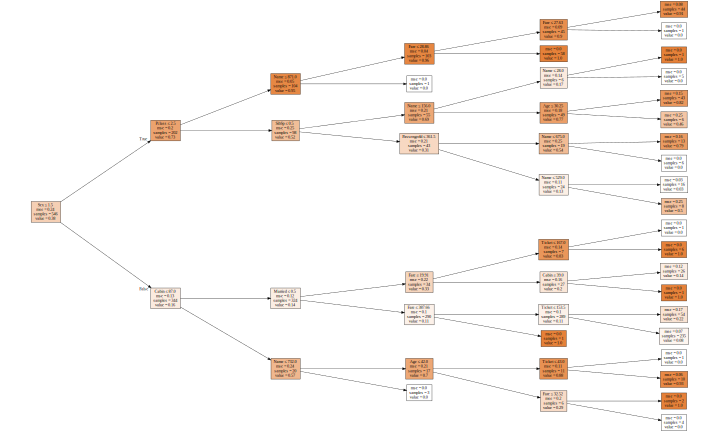

In [51]:
draw_tree(m.estimators_[0], x_train, precision=2)

A tree is a sequence of binary decisions/ splits. The first split in this tree was on sex <=1.5.

the average of survival rate was 0.393, and if we built a model where we used the average to predict the survival rate, then our mse would be 0.239. This is like the denominator of an R Squared.

    The best split we can make is to split the data in half at Sex = Male or Female. Within the group of Sex = Female, predicting the mean  is a far more accurate prediction than in the rest of the dataset - in this sub group, predicting the mean will yield a mean square error of only 0.19. 
    
At each step in the tree, we split the data in two for each column, for each possible value of each column, and see what split yields the greatest recuction in the root mean squared errors. so after step 1 Sex = Male or Female, the two new groups have mse 0.184 * 177 samples, plus mse 0.145 * 176 samples. 

Before the split, the total error was 0.238 * 473 = 112.5
After the split the sum of errors is 32.5 and this is the biggest improvement we can make with one split. 

If we allow the tree to split all the way so that the leaf nodes only contain one sample each, then the R Squared on the training set will be 1.0, since the model has split so far down and it will know exactly the survival outcome of the person with that set of splits. 





In [52]:
(0.184*177) + (0.145*0.176) # After split 1


32.59352

In [53]:
0.238*473 # before split 1

112.574


## What is bagging?
averaging across different models - ensembling. 

Random forests is a way of bagging random trees. 

Many different models may be massively overfit, but each contain a different insight into the data. 

Taking a random subset of the data each time, we can make an overfitting tree from each of the subsets of the data. Each tree will make real predictions, but will contain errors. These errors will be random, but because we have many trees we can take the average prediction across all the trees, and since the average of some random numbers is zero we can assume the overfitting will average out, leaving the tree relationship. 


Uncorrelatedness between trees is more important than the accuracy of each individaul tree. There is a scikitlearn module called <strong>ExtraTreesRegressor </strong> - rather than trying every split of each variable, it randomly splits the variables, so it takes less time becase there are fewer splits, and each tree is less predictive, but the trees are less correlated with each other and when averaged out they produce good models. 


### How does the random forest work in practice?
First the trees are constructed from random samples of the training set. For each of the lines in the validation set, each line is run through the first tree until it reaches a leaf node, then the average value at that leaf node is noted. This is done for each line of the validation set, for each tree, then the average of all the trees averages is taken and used as the final predictor for each line in the validation set. 



Let's look at our original model to investigate bagging a little further


In [54]:




m = RandomForestRegressor(n_jobs=-1, max_depth=5, n_estimators = 200, min_samples_leaf = 3, bootstrap=True, oob_score=True)
m.fit(df, y)
print_score(m)



rmse train: 0.3049732620021904 Training set size: 791 
rmse validation: 0.2754441522783538 Validation set size: 100 
Rsquared train: 0.607885112166191 
RSquared valid: 0.6707053774985201
OOB: 0.4653964649593365


In [55]:
preds = np.stack([t.predict(df) for t in m.estimators_])
preds.shape
#f'Predictions: {preds[:,0].round(2)} ',f'mean Predictions: {np.mean(preds[:,0])} ',f'y_Valid: {y_valid[0]}'

(200, 891)

Noice how none of the indivudual estimators tend to  be that close to the RSquared in the validation set, but the average of the estimators is with in 0.03 

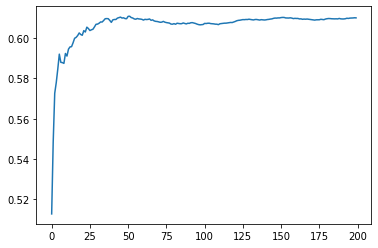

In [56]:
plt.plot([metrics.r2_score(y, np.mean(preds[:i+1], axis=0)) for i in range(200)])

The plot above shows the average RSquared values of an increaing <strong>number of estimators</strong>. The accuracy increases for a bit and levels off around 40 estimators. This is one of our <strong>hyperparameters</strong>

In [57]:
preds.shape

(200, 891)

## Other Hyperparameter tunings:

### 

## Out of bag score
The out of bag score is <b>not</b> ' a score which works straight out of the bag'
it is a score whose validation set is made up of the samples which were not picked during the random samples taken for bagging. 

In practice what this means is when we make the validation set, we go through all the data making predictions for each row of the dataset based on all of the trees for which this row was not in the training set. 

To use the OOB score , include the kwarg oob_score=True in the random forest regressor function. 

In [58]:
df.shape

(891, 13)

## Reducing Over Fitting
### subsampling

Earlier we used a random subset of 30000 samples to speed things up, but if we are using bagging to take random samples of the dataset, it doesn't make sense to be only taking from a small subset of 30000, we could be taking form the entire dateset, no matter how large it is, and it would be just as fast. 

To access this function use the entire dataset for df_trn, but run 

    set_rf_samples(20000)
    
This trains trees on a smaller subset, but with enough trees, eventually the model will see everything. 


### Set RF Samples 
to sample a smaller subset each time

In [59]:
set_rf_samples(500)

In [56]:
??reset_rf_samples()

Object `reset_rf_samples()` not found.


The set_rf_samples method and the OOB_Score are not currently compatible with each other - this may change in later versions, but at the moment with fastai v1, to use set_rf_samples, oob_score needs to be set to False, and to use oob_score again, run <b>reset_rf_samples()</b>

### ExtraTreesRegressor
selects from a smaller set of independent variables at each split

In [61]:
mE=ExtraTreesRegressor(n_estimators = 500,n_jobs=-1, oob_score=True, bootstrap=True)
mE.fit(df, y)
custom_print_score(m, df, y)



rmse train: 0.30368272964351184 Total set size: 891 
Rsquared train: 0.6100605755043658
OOB: 0.46310747875613845


When experimenting to figure out hyperparameters, for feature optimization, run most of your models on a small subset of the data, then the models are running in 10s, then finally run the whole dataset. 

In [62]:
m.n_estimators

200

# Hyperparameters
### Number of estimators
Described above
### OOB Score
Do not understand how to tune this yet
### Min Samples Leaf
'Stop training the tree further when your leaf node has 3 or less samples in. one or two less decisions being made so trains more quickly - more general trees but each tree less powerful on its own.  
<b>one, three, five, ten, 25, or hundreds or thousands if its a huge dataset. </b>

## Effect of more general leaf nodes -
<b>very definite leaf nodes</b> with one sample in each leaf end up being <b> less predictive </b> on the validation set because the model overfits to the test set too much. The plot below shows the effect of increasing the number of samples in each leaf node - at first the less specific leaves yield a better general result, but after a point the leaves are not predictive enough and the predictions become less accurate. 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


AttributeError: 'Line2D' object has no property 'xlabel'

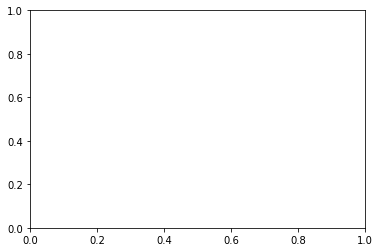

In [106]:
leaf_sizes = [n+1 for n in range(20)]
print(leaf_sizes)
msl = [RandomForestRegressor(n_estimators=200, n_jobs=-1, min_samples_leaf = x) for x in leaf_sizes]

[msl[n].fit(x_train,y_train) for n in range(len(msl))]

plt.plot([metrics.r2_score(y_valid, msl[i].predict(x_valid)) for i in range(len(msl))], xlabel='min_samples_leaf')

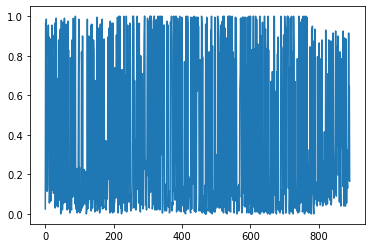

In [105]:
plt.plot(msl[0].predict(df))


### max_features = 0.5
##### also sqrt, log2, auto.
The less correlated our trees are the better. 
If this kwarg is passed, then each decision in the tree is made from a random subset of half of the columns. This avoids the situation where there might be one extremely predictive column, which is always the strongest predictor,and each tree would share this column in common. It makes sense to have some trees not include this column, since whilst the column is a strong predictor, it is still not a perfect predictor, and there might be more information which is available by averaging with a tree which has its first split at a different datapoint. 

This sampling happens at each split - so year made is always still available at each split

### How deep is your tree?

In [63]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right
    

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [64]:
# m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
# m.fit(x_train, y_train)
# print_score(m)

In [65]:
t=m.estimators_[0].tree_
dectree_max_depth(t)

6

This tree only has <b>16 splits</b>

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [66]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=5, max_depth=5, n_jobs=-1, oob_score=True)
m.fit(df, y)
custom_print_score(m, df, y)

rmse train: 0.3065462556097277 Total set size: 891 
Rsquared train: 0.6026721667279531
OOB: 0.4645832922882994


In [67]:
t=m.estimators_[0].tree_
dectree_max_depth(t)

6

This tree only has <b>6 splits</b>

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

In [119]:
m = RandomForestRegressor(n_estimators=1000, max_depth=7, min_samples_leaf=3, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

rmse train: 0.2919457251153172 Training set size: 791 
rmse validation: 0.3350744345463374 Validation set size: 100 
Rsquared train: 0.6406695323168247 
RSquared valid: 0.5126958477146366
OOB: 0.4577974451594907


## Finding patterns outside the forest
It is possible to find correlations between columns in the dataset and the dependent variable before even running the random forest model:

In [69]:
women = df_raw.loc[df_raw.Sex == 'female']["Survived"]

In [70]:
rate_women = sum(women) / len(women)
print(f'{rate_women * 100}% of women survived')

74.20382165605095% of women survived


In [71]:
men = df_raw.loc[df_raw.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)
print(f'{rate_men * 100}% of men survived')

18.890814558058924% of men survived


## First attempt at predicting from the testset

In [120]:
testset = pd.read_csv('data/titanic/test.csv')

In [121]:
features = feature_extract(testset.Name, strings)

testset.insert(3, "Married", features, True)
#testset.insert(2, "dummy", 0, True)

In [122]:
df_test, _  , nas_test = proc_df(testset)

In [124]:
df_test.pop('Fare_na')
predictions = m.predict(df_test)
df_test

KeyError: 'Fare_na'

In [125]:
predictions[0:100].round(1).sum()/100


0.42700000000000005

Originally I was getting a weird value of 70% here - it was because I inserted the Married column in the wrong place in the test set, which meant that Sex and Married were in opposite columns to each other in the training and test set. Since Sex is such an imortant predictor (70% of women survived on the ship), most trees were splitting at sex <=1.5 (after filling NA values as -1 then adding 1 to the column, 1 ended up being female and 2 = Male). The Married column only ran from 0 to 1 so the model thought all the people in the test set were female - hence the 70% prediction. 

A prediction of 41% survival rate is much closer to the mark. 

In [78]:
df_test.head()

,PassengerId,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,892,3,207,1,2,34.5,0,0,153,7.8292,0,2,False
1,893,3,404,1,1,47.0,1,0,222,7.0000,0,3,False
2,894,2,270,1,2,62.0,0,0,74,9.6875,0,2,False
3,895,3,409,1,2,27.0,0,0,148,8.6625,0,3,False
4,896,3,179,1,1,22.0,1,1,139,12.2875,0,3,False


In [79]:
df.head()

,PassengerId,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,109,1,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,191,1,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,354,0,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,273,1,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,16,1,2,35.0,0,0,473,8.0500,0,3,False


In [80]:
m.predict(df_test).sum()/len(m.predict(df_test))

0.41426596628678747

In [81]:
preds = np.stack([t.predict(df_test) for t in m.estimators_])

In [85]:
preds[0][1]

0.5555555555555556

The predictions are given as probabilities rather than 1 or 0 binary values - we need to round each item in the array for the competition submission. 

In [126]:
binary_predictions = predictions.round()

In [127]:
int_binary_predictions = [int(x) for x in binary_predictions]


In [128]:
len(int_binary_predictions)

418

## Exporting to CSV


In [131]:
output = pd.DataFrame({"PassengerId" : df_test.PassengerId, "Survived": int_binary_predictions})

sum(output.Survived)/len(output.Survived)

0.37559808612440193

What portion of the passengers in the testset are female?

In [115]:
sum(df_test.Sex == 1)/len(df_test.Sex)

0.36363636363636365

In [132]:
output.to_csv('my_titanic_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
